In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as tf
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [2]:
dfi = pd.read_csv('./Data/Stock/^HSI.csv',parse_dates=True,index_col='Datetime')
dfi

,Close,High,Low,Open
Datetime,,,,
2022-10-31 01:30:00+00:00,14866.889648,14958.959961,14597.309570,14830.690430
2022-10-31 02:30:00+00:00,14925.740234,15026.799805,14853.129883,14864.419922
2022-10-31 03:30:00+00:00,14995.009766,15006.629883,14904.570312,14928.030273
2022-10-31 04:30:00+00:00,14956.820312,15113.150391,14946.570312,14978.459961
2022-10-31 05:30:00+00:00,14865.980469,14998.719727,14824.809570,14957.780273
...,...,...,...,...
2024-10-29 01:30:00+00:00,20828.210938,20890.080078,20677.710938,20729.980469
2024-10-29 02:30:00+00:00,20691.460938,20869.339844,20676.210938,20830.669922
2024-10-29 03:30:00+00:00,20593.339844,20696.419922,20570.259766,20690.539062


In [3]:
# df = dfi.loc[dfi['pickup_datetime'] > '2016-08-01']
# df

In [4]:
df = dfi[['Open','High','Low','Close']]
df = df.dropna()
#df = df.reset_index(drop=True)
df

,Open,High,Low,Close
Datetime,,,,
2022-10-31 01:30:00+00:00,14830.690430,14958.959961,14597.309570,14866.889648
2022-10-31 02:30:00+00:00,14864.419922,15026.799805,14853.129883,14925.740234
2022-10-31 03:30:00+00:00,14928.030273,15006.629883,14904.570312,14995.009766
2022-10-31 04:30:00+00:00,14978.459961,15113.150391,14946.570312,14956.820312
2022-10-31 05:30:00+00:00,14957.780273,14998.719727,14824.809570,14865.980469
...,...,...,...,...
2024-10-29 01:30:00+00:00,20729.980469,20890.080078,20677.710938,20828.210938
2024-10-29 02:30:00+00:00,20830.669922,20869.339844,20676.210938,20691.460938
2024-10-29 03:30:00+00:00,20690.539062,20696.419922,20570.259766,20593.339844


In [5]:
df['nxt_target'] = df['Close'].shift(-1)
df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]

/tmp/ipykernel_66405/2437957435.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]
/tmp/ipykernel_66405/2437957435.py:2: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3410 entries, 2022-10-31 01:30:00+00:00 to 2024-10-29 05:30:00+00:00
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        3410 non-null   float64
 1   High        3410 non-null   float64
 2   Low         3410 non-null   float64
 3   Close       3410 non-null   float64
 4   nxt_target  3410 non-null   float64
dtypes: float64(5)
memory usage: 159.8 KB


In [7]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,Open,High,Low,Close,nxt_target
Datetime,,,,,
2022-10-31 01:30:00+00:00,14830.690430,14958.959961,14597.309570,14866.889648,14925.740234
2022-10-31 02:30:00+00:00,14864.419922,15026.799805,14853.129883,14925.740234,14995.009766
2022-10-31 03:30:00+00:00,14928.030273,15006.629883,14904.570312,14995.009766,14956.820312
2022-10-31 04:30:00+00:00,14978.459961,15113.150391,14946.570312,14956.820312,14865.980469
2022-10-31 05:30:00+00:00,14957.780273,14998.719727,14824.809570,14865.980469,14720.950195
...,...,...,...,...,...
2024-06-05 05:30:00+00:00,18520.050781,18530.349609,18453.769531,18474.339844,18444.419922
2024-06-05 06:30:00+00:00,18474.710938,18475.189453,18410.869141,18444.419922,18424.960938
2024-06-05 07:30:00+00:00,18445.679688,18453.880859,18375.269531,18424.960938,18519.400391


In [8]:
train.iloc[:,-1:]

,nxt_target
Datetime,
2022-10-31 01:30:00+00:00,14925.740234
2022-10-31 02:30:00+00:00,14995.009766
2022-10-31 03:30:00+00:00,14956.820312
2022-10-31 04:30:00+00:00,14865.980469
2022-10-31 05:30:00+00:00,14720.950195
...,...
2024-06-05 05:30:00+00:00,18444.419922
2024-06-05 06:30:00+00:00,18424.960938
2024-06-05 07:30:00+00:00,18519.400391


In [9]:
train.iloc[:,:4]

,Open,High,Low,Close
Datetime,,,,
2022-10-31 01:30:00+00:00,14830.690430,14958.959961,14597.309570,14866.889648
2022-10-31 02:30:00+00:00,14864.419922,15026.799805,14853.129883,14925.740234
2022-10-31 03:30:00+00:00,14928.030273,15006.629883,14904.570312,14995.009766
2022-10-31 04:30:00+00:00,14978.459961,15113.150391,14946.570312,14956.820312
2022-10-31 05:30:00+00:00,14957.780273,14998.719727,14824.809570,14865.980469
...,...,...,...,...
2024-06-05 05:30:00+00:00,18520.050781,18530.349609,18453.769531,18474.339844
2024-06-05 06:30:00+00:00,18474.710938,18475.189453,18410.869141,18444.419922
2024-06-05 07:30:00+00:00,18445.679688,18453.880859,18375.269531,18424.960938


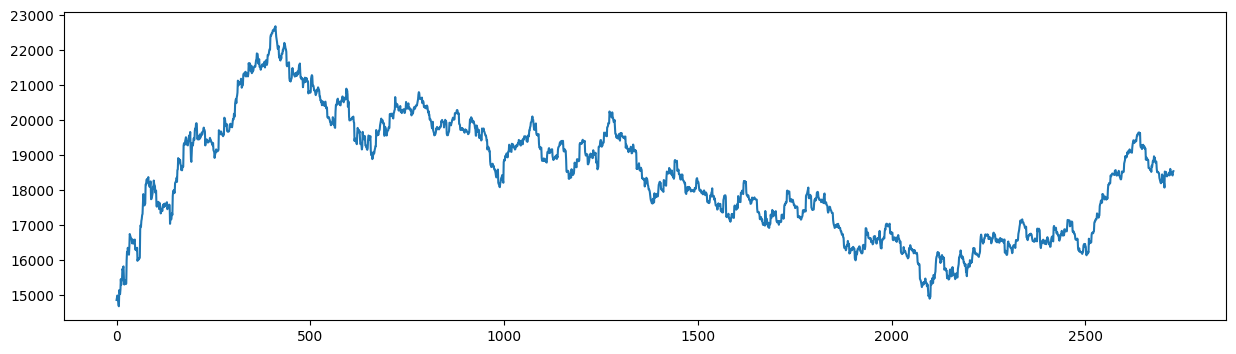

In [10]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["Close"])
plt.show()

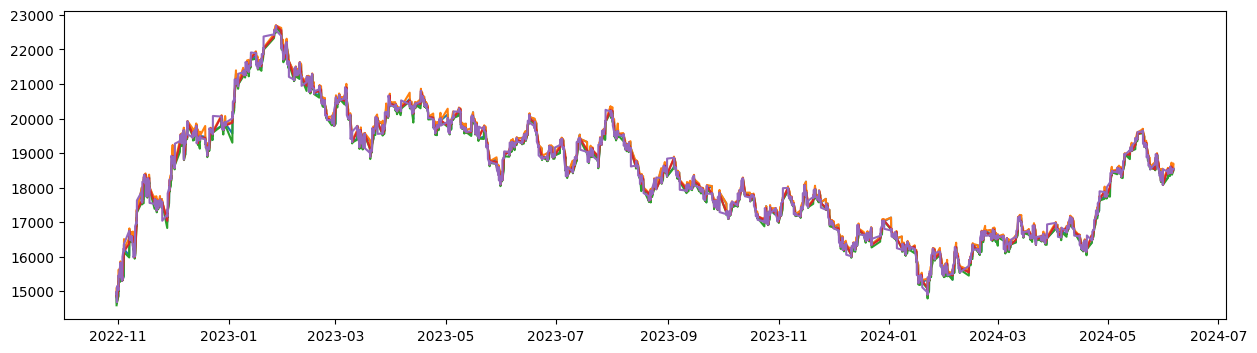

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [12]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:])
    data = scaler2.fit_transform(data.iloc[:,:4])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [13]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 4
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 4
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [14]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [15]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [16]:
print(X_train.shape)
batch_size, seq_length, features_size =X_train.size()
print(batch_size)
X_train[0][0]

torch.Size([2718, 10, 4])
2718


tensor([-2.1479, -2.1008, -2.2626, -2.1284])

In [17]:
device = "cpu"

In [18]:
def init_hidden(x: torch.Tensor, hidden_size: int, num_dir: int = 1, xavier: bool = True):
    
    if xavier:
        return nn.init.xavier_normal_(torch.zeros(num_dir, x.size(0), hidden_size)).to(device)
    return Variable(torch.zeros(num_dir, x.size(0), hidden_size)).to(device)

In [19]:
class AttnEncoder(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, batch_first: bool = True,seq_len:int=10):
        
        super(AttnEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        
        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=1
        )
        self.attn = nn.Linear(
            in_features=2 * self.hidden_size + self.seq_len,
            out_features=1
        )
        self.softmax = nn.Softmax(dim=1)

    
    def forward(self, input_data: torch.Tensor):
        
        h_t, c_t = (init_hidden(input_data, self.hidden_size),
                    init_hidden(input_data, self.hidden_size))

        attentions, input_encoded = (Variable(torch.zeros(input_data.size(0), self.seq_len, self.input_size)),
                                     Variable(torch.zeros(input_data.size(0), self.seq_len, self.hidden_size)))

        
        for t in range(self.seq_len):
            x = torch.cat((h_t.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           c_t.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           input_data.permute(0, 2, 1).to(device)), dim=2).to(
                device)  # bs * input_size * (2 * hidden_dim + seq_len)

            e_t = self.attn(x.view(-1, self.hidden_size * 2 + self.seq_len))  # (bs * input_size) * 1
            a_t = self.softmax(e_t.view(-1, self.input_size)).to(device)  # (bs, input_size)

            weighted_input = torch.mul(a_t, input_data[:, t, :].to(device))  # (bs * input_size)
            self.lstm.flatten_parameters()
            _, (h_t, c_t) = self.lstm(weighted_input.unsqueeze(0), (h_t, c_t))

            input_encoded[:, t, :] = h_t
            attentions[:, t, :] = a_t

        return attentions, input_encoded

In [20]:
class AttnDecoder(nn.Module):
    def __init__(self,  hidden_size: int, batch_first: bool = True,seq_len:int=10):
        
        super(AttnDecoder, self).__init__()
        self.seq_len = seq_len
        self.encoder_hidden_size = hidden_size
        self.decoder_hidden_size = hidden_size
        self.out_feats = 1

        self.attn = nn.Sequential(
            nn.Linear(2 * self.decoder_hidden_size + self.encoder_hidden_size, self.encoder_hidden_size),
            nn.Tanh(),
            nn.Linear(self.encoder_hidden_size, 1)
        )
        self.lstm = nn.LSTM(input_size=self.out_feats, hidden_size=self.decoder_hidden_size)
        self.fc = nn.Linear(self.encoder_hidden_size + self.out_feats, self.out_feats)
        self.fc_out = nn.Linear(self.decoder_hidden_size + self.encoder_hidden_size, self.out_feats)
        self.fc.weight.data.normal_()

    def forward(self, input_encoded: torch.Tensor, y_history: torch.Tensor):
        
        h_t, c_t = (
            init_hidden(input_encoded, self.decoder_hidden_size), init_hidden(input_encoded, self.decoder_hidden_size))
        context = Variable(torch.zeros(input_encoded.size(0), self.encoder_hidden_size))

        for t in range(self.seq_len):
            x = torch.cat((h_t.repeat(self.seq_len, 1, 1).permute(1, 0, 2),
                           c_t.repeat(self.seq_len, 1, 1).permute(1, 0, 2),
                           input_encoded.to(device)), dim=2)

            x = tf.softmax(
                self.attn(
                    x.view(-1, 2 * self.decoder_hidden_size + self.encoder_hidden_size)
                ).view(-1, self.seq_len),
                dim=1)

            context = torch.bmm(x.unsqueeze(1), input_encoded.to(device))[:, 0, :]  # (batch_size, encoder_hidden_size)
            #print('context yhis',context.to(device).size(), y_history.to(device).size())
            y_tilde = self.fc(torch.cat((context.to(device), y_history.to(device)),
                                        dim=1))  # (batch_size, out_size)

            self.lstm.flatten_parameters()
            _, (h_t, c_t) = self.lstm(y_tilde.unsqueeze(0), (h_t, c_t))

        return self.fc_out(torch.cat((h_t[0], context.to(device)), dim=1))  # predicting value at t=self.seq_length+1



In [21]:
class AutoEncForecast(nn.Module):
    def __init__(self,input_size: int, hidden_size: int, batch_first: bool = True, n_qubits:int=4, n_qlayers:int=1,seq_len:int=10):
        super(AutoEncForecast, self).__init__()
        self.encoder = AttnEncoder(input_size, hidden_size, batch_first,seq_len).to(device)
        self.decoder = AttnDecoder(hidden_size, batch_first, seq_len).to(device)

    def forward(self, encoder_input: torch.Tensor, y_hist: torch.Tensor, return_attention: bool = False):
       
        attentions, encoder_output = self.encoder(encoder_input)
        outputs = self.decoder(encoder_output, y_hist.float())
        outputs = torch.transpose(outputs, 0, 1)
        if return_attention:
            return outputs, attentions
        return outputs

In [22]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = AutoEncForecast(input_size=4, hidden_size= 6)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

In [23]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)
count = 0


for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        
        output = modelQ(x,y)
        
        label = torch.transpose(y, 0, 1)    
        #print(output)
        #print(torch.transpose(y, 0, 1))
        
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/5]  LossQ:41.20574208588641 
[2/5]  LossQ:3.999885476788222 
[3/5]  LossQ:1.8993257684956006 
[4/5]  LossQ:1.1248122877727837 
[5/5]  LossQ:0.8881397714463333 


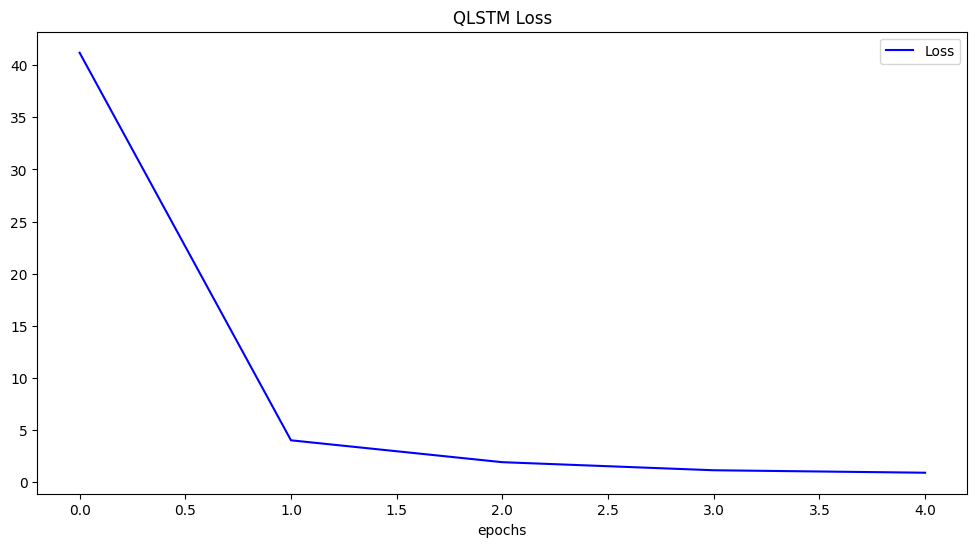

In [24]:
np.savetxt('./SavedModels/Stock/HSI/loss/clstm_attn.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [25]:
print(len(X_test))
print(len(X_train))
print(len(y_train))
#print(X_train[0].unsqueeze(0))
#print(y_train[0].unsqueeze(0))

672
2718
2718


In [26]:
def predict(X,y, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for i in range(len(X)):
            y_star = model(X[i].unsqueeze(0),y[i].unsqueeze(0))
            '''if list(y_star.size()) == [1,1]:
                y_star = y_star.tolist()
                y_star[0]+= [y_star[0][0]]
                y_star[0]+= [y_star[0][0]]
                y_star[0]+= [y_star[0][0]]
                y_star = torch.tensor(y_star)'''
            output = torch.cat((output, y_star), 0)


    return output

In [27]:
pred_y_test = predict(X_test,y_test, modelQ)
print(len(pred_y_test))
print(pred_y_test)

672
tensor([[-0.0212],
        [-0.2448],
        [-0.2115],
        [-0.2109],
        [-0.2121],
        [-0.0929],
        [-0.1452],
        [-0.1405],
        [-0.3021],
        [-0.2863],
        [-0.3085],
        [-0.2668],
        [-0.2640],
        [-0.3067],
        [-0.2842],
        [-0.2459],
        [-0.2405],
        [-0.2211],
        [-0.2283],
        [-0.2242],
        [-0.1865],
        [-0.1671],
        [-0.2657],
        [-0.2204],
        [-0.2495],
        [-0.2377],
        [-0.2453],
        [-0.2525],
        [-0.2860],
        [-0.2111],
        [-0.2250],
        [-0.2567],
        [-0.2514],
        [-0.2830],
        [-0.2777],
        [-0.2869],
        [-0.2602],
        [-0.2741],
        [-0.3080],
        [-0.2878],
        [-0.3087],
        [-0.2923],
        [-0.2996],
        [-0.1191],
        [-0.0658],
        [-0.0734],
        [-0.0524],
        [-0.0175],
        [ 0.0094],
        [ 0.0391],
        [ 0.0469],
        [-0.0337],
        

In [28]:
pred_y_train = predict(X_train,y_train, modelQ)
print(len(pred_y_train))
print(pred_y_train)

2718
tensor([[-1.5512],
        [-1.6100],
        [-1.5541],
        ...,
        [ 0.0777],
        [ 0.0935],
        [ 0.0853]])


In [29]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [30]:
print(len(pred_y_train))
print(len(y_train))

2718
2718


In [31]:
pred_y_test

tensor([[-0.0212],
        [-0.2448],
        [-0.2115],
        [-0.2109],
        [-0.2121],
        [-0.0929],
        [-0.1452],
        [-0.1405],
        [-0.3021],
        [-0.2863],
        [-0.3085],
        [-0.2668],
        [-0.2640],
        [-0.3067],
        [-0.2842],
        [-0.2459],
        [-0.2405],
        [-0.2211],
        [-0.2283],
        [-0.2242],
        [-0.1865],
        [-0.1671],
        [-0.2657],
        [-0.2204],
        [-0.2495],
        [-0.2377],
        [-0.2453],
        [-0.2525],
        [-0.2860],
        [-0.2111],
        [-0.2250],
        [-0.2567],
        [-0.2514],
        [-0.2830],
        [-0.2777],
        [-0.2869],
        [-0.2602],
        [-0.2741],
        [-0.3080],
        [-0.2878],
        [-0.3087],
        [-0.2923],
        [-0.2996],
        [-0.1191],
        [-0.0658],
        [-0.0734],
        [-0.0524],
        [-0.0175],
        [ 0.0094],
        [ 0.0391],
        [ 0.0469],
        [-0.0337],
        [-0.

In [32]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [33]:
np.savetxt('./SavedModels/Stock/HSI/train/clstm_attn.txt',y_train_pred)
np.savetxt('./SavedModels/Stock/HSI/test/clstm_attn.txt',y_test_pred)

Training dataset RMSE:209.54829267866825


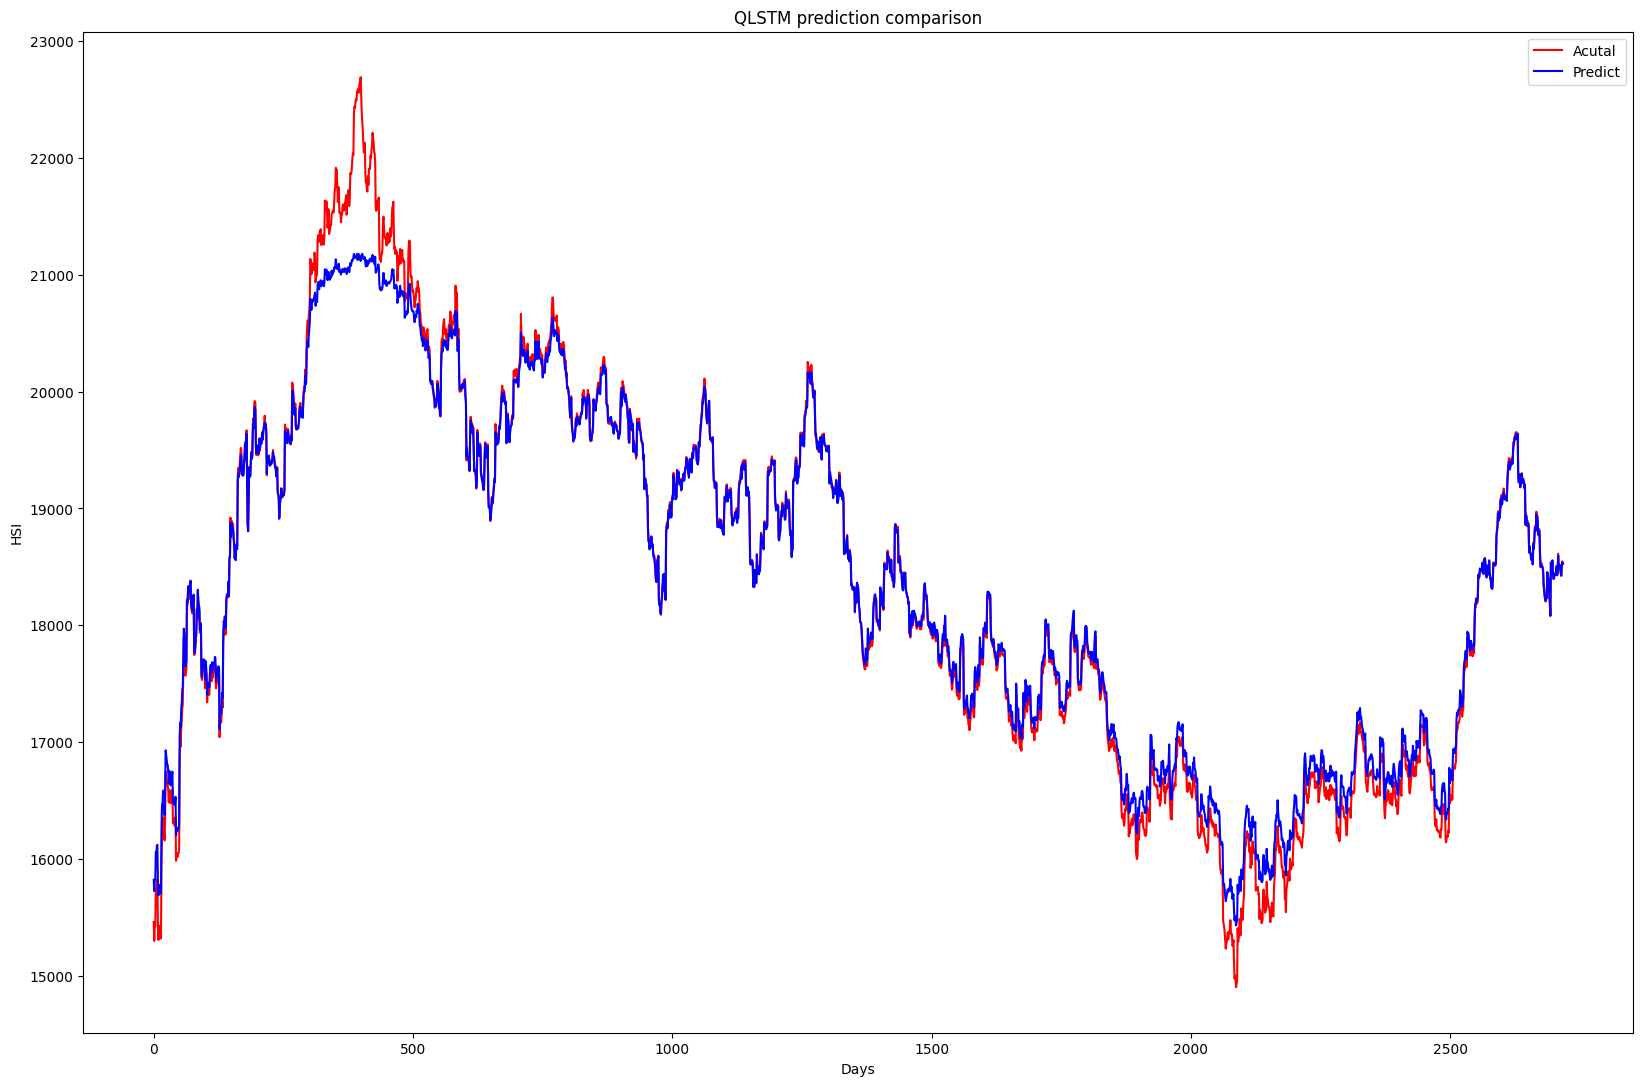

In [34]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('HSI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:352.9844047752545


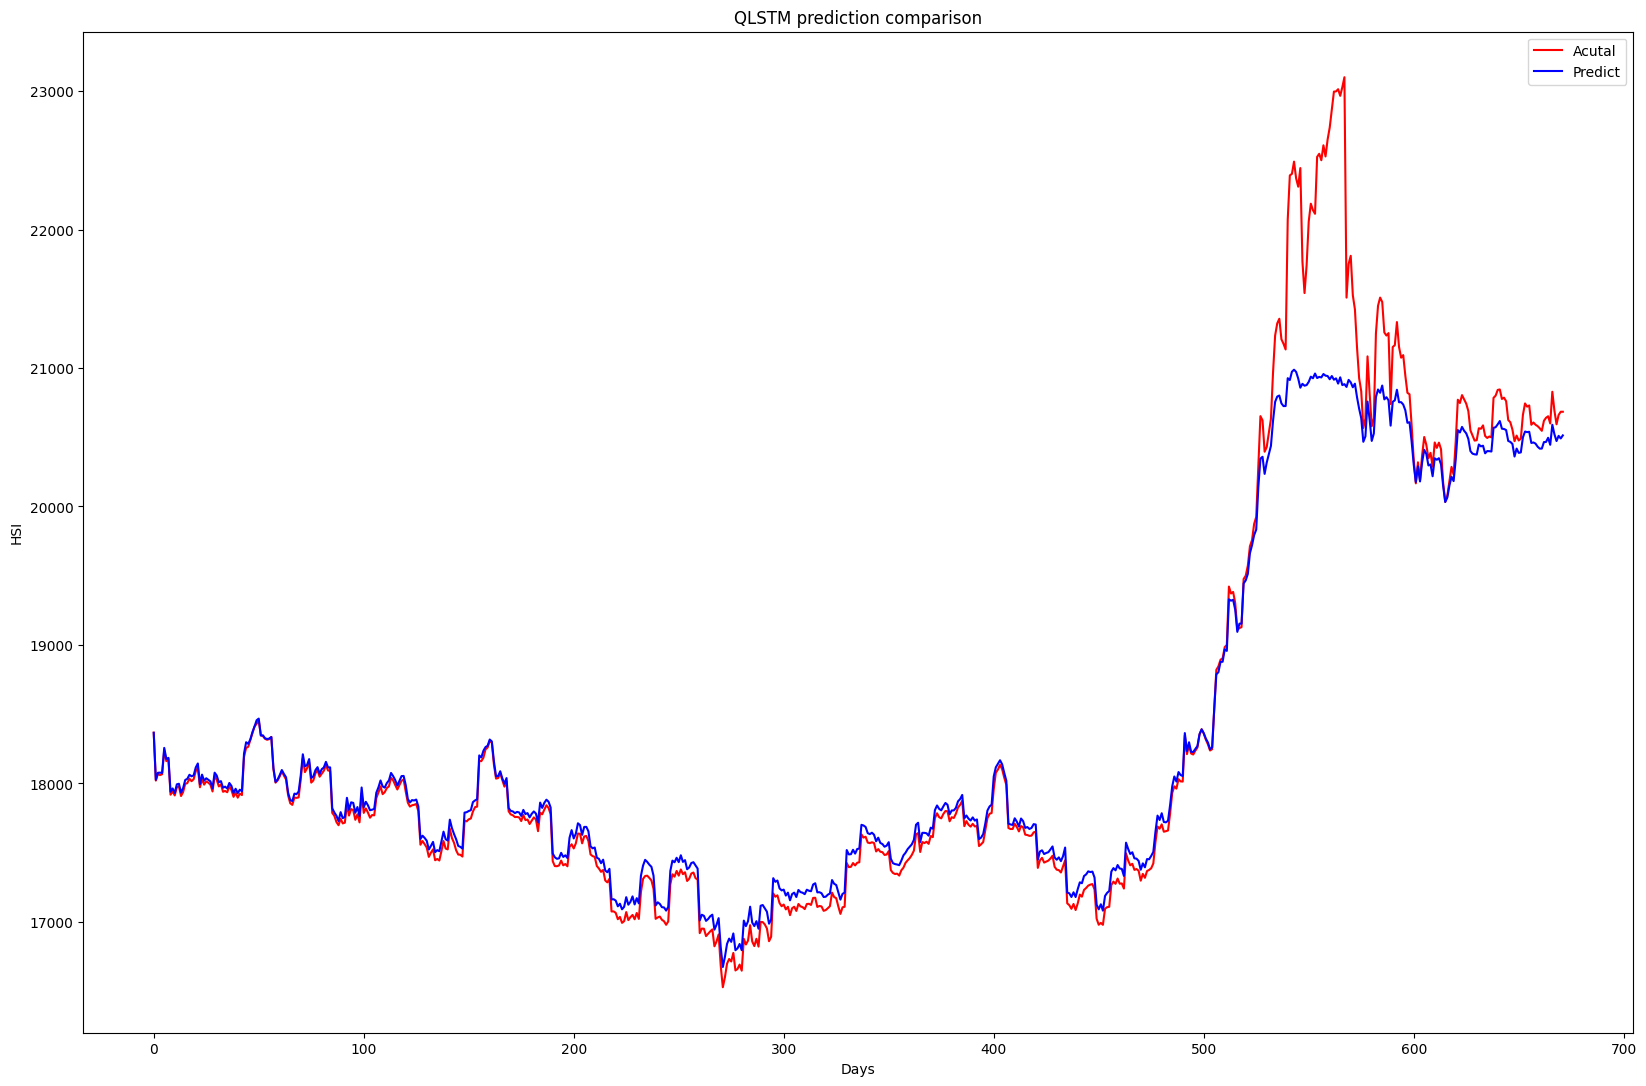

In [35]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('HSI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [36]:
torch.save(modelQ,'./SavedModels/Stock/HSI/model/CLSTM_attn_aqi')